In [1]:
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
import altair as alt
import spacy
from tqdm import tqdm
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

nlp = spacy.load("en_core_web_sm")

In [ ]:

# Create a directory to store PDFs
save_dir = "africa_media_review_pdfs"
os.makedirs(save_dir, exist_ok=True)

# Step 1: Collect all links
start_range = 0
increment = 100
all_links = []
for i in range(0, 300, increment):
	url = f"https://d.lib.msu.edu/search?sort=title%20asc&fq=RELS_EXT_isMemberOfCollection_uri_s%3Ainfo%5C%3Afedora/jamr%5C%3Aroot&start={i}&rows={increment}"
	response = requests.get(url)
	print(response.status_code)
	soup = BeautifulSoup(response.content, "html.parser")
	results = soup.find_all("h2", class_="sh-result-label")
	links = ["https://d.lib.msu.edu" + result.find("a")["href"] for result in results]
	all_links.extend(links)

print(f"Total articles found: {len(all_links)}")

# Store links in a DataFrame
all_links_df = pd.DataFrame(all_links, columns=["collection_item_link"])
# all_links_df = all_links_df[0:1]
# Step 2: Extract metadata, OCR, and download PDFs
all_metadata = []

for index, row in all_links_df.iterrows():
	page_url = row["collection_item_link"]
	response = requests.get(page_url)
	if response.status_code != 200:
		print(f"Failed to retrieve {page_url}")
		continue
	
	soup = BeautifulSoup(response.content, "html.parser")

	# Extract title
	title_element = soup.find("h1")
	title = title_element.text.strip() if title_element else "No title found"

	# Extract abstract
	abstract_element = soup.find("div", class_="sh-block-collapse")
	abstract = abstract_element.text.strip() if abstract_element else "No abstract found"

	# Extract OCR transcript
	transcript_url = page_url + "/FULL_TEXT/view"
	transcript_response = requests.get(transcript_url)
	transcript_text = transcript_response.text if transcript_response.status_code == 200 else "No transcript available"

	# Extract metadata into a structured dictionary
	metadata_dict = {"title": title, "abstract": abstract, "transcript": transcript_text, "transcript_url": transcript_url}

	metadata_rows = soup.find_all("dl", class_="row my-3")

	for row in metadata_rows:
		dt_element = row.find("dt")
		dd_element = row.find("dd")

		if dt_element and dd_element:
			key = dt_element.text.strip()
			key = key.replace(" ", "_").replace(":", "").lower()
			value_text = dd_element.text.strip()
			link_element = dd_element.find("a")
			value_link = link_element["href"] if link_element else None

			# Store text + hyperlink if available
			if key != 'part_of':
				metadata_dict[key] = f"{value_text} ({value_link})" if value_link else value_text
			else:
				metadata_dict[key] = value_text

	filename = f"{page_url.split('edu/')[-1].replace('/', '_')}.pdf"
	filepath = os.path.join(save_dir, filename)
	metadata_dict["filename"] = filepath
	# Download PDF with unique filename
	pdf_download_url = page_url + "/OBJ/download"
	pdf_response = requests.get(pdf_download_url)
	if pdf_response.status_code == 200:
		with open(filepath, "wb") as f:
			f.write(pdf_response.content)
		print(f"Downloaded PDF: {filename}")
	else:
		print(f"Failed to download PDF for {title}")

	# Append to metadata list
	all_metadata.append(metadata_dict)

# Convert metadata list to a DataFrame with metadata fields as columns
metadata_df = pd.DataFrame(all_metadata)

# Merge with the original links DataFrame
final_df = all_links_df.merge(metadata_df, left_index=True, right_index=True)


print("Scraping and processing completed.")
final_df['start_page'] = final_df.pages.str.split('-').str[0].str.split('Pages ').str[1]
final_df['end_page'] = final_df.pages.str.split('-').str[1]
final_df['start_page'] = final_df['start_page'].str.replace(' ', '')
final_df['end_page'] = final_df['end_page'].str.replace(' ', '')

200
200
200
Total articles found: 293
Scraping and processing completed.


In [3]:
final_df.to_csv("africa_media_review_dataset.csv", index=False)

In [4]:
final_df.sort_values(by=['date_published', 'start_page']).head(5)

,collection_item_link,title,abstract,transcript,transcript_url,in_collections,copyright_status,date_published,authors,subjects,material_type,publishers,language,pages,part_of,issn,permalink,filename,start_page,end_page
44,https://d.lib.msu.edu/jamr/50,Communication as technology in African rural d...,The article defines technology as a communicat...,Africa Media Review Vol. 1. No. 1. 1986 \r\n© ...,https://d.lib.msu.edu/jamr/50/FULL_TEXT/view,Africa Media Review (/jamr),In Copyright,1986-06,"Ugboajah, Frank Okwu (/search?fq=name_author:U...",Communication and technology\n\nCommunication ...,Articles (/search?fq=genre_aat:Articles),Institute for Communication Development and Re...,English,Pages 1-19,Africa media review. Vol. 1 no. 1 (1986 June),0258-4913,https://n2t.net/ark:/85335/m5mk68b1x (https://...,africa_media_review_pdfs/jamr_50.pdf,1,19
31,https://d.lib.msu.edu/jamr/58,Book review : Reporting Africa: a manual for r...,No abstract found,Ifrira Media Kviien Vol. 1 No. I I')H<> \r\n© ...,https://d.lib.msu.edu/jamr/58/FULL_TEXT/view,Africa Media Review (/jamr),In Copyright,1986-06,"Nwosu, Ikechukwu Enoch (/search?fq=name_author...",NaN,Reviews (documents) (/search?fq=genre_aat:Revi...,Institute for Communication Development and Re...,English,Pages 112-115,Africa media review. Vol. 1 no. 1 (1986 June),0258-4913,https://n2t.net/ark:/85335/m5x63f75f (https://...,africa_media_review_pdfs/jamr_58.pdf,112,115
47,https://d.lib.msu.edu/jamr/59,Communication for rural development in Africa ...,No abstract found,Africa Media Review Vol. 1. No. 1. 1986 \r\n©A...,https://d.lib.msu.edu/jamr/59/FULL_TEXT/view,Africa Media Review (/jamr),In Copyright,1986-06,"Bosompra, Kwadwo (/search?fq=name_author:Bosom...",Communication in rural development (/search?fq...,Articles (/search?fq=genre_aat:Articles),Institute for Communication Development and Re...,English,Pages 116-122,Africa media review. Vol. 1 no. 1 (1986 June),0258-4913,https://n2t.net/ark:/85335/m5cv4ft70 (https://...,africa_media_review_pdfs/jamr_59.pdf,116,122
51,https://d.lib.msu.edu/jamr/51,"Compelling impacts of the telephone, literacy ...","The article explores the role which literacy, ...",Africa Media Review Vol. 1. No. 1. 1986 \r\n©A...,https://d.lib.msu.edu/jamr/51/FULL_TEXT/view,Africa Media Review (/jamr),In Copyright,1986-06,"Edeani, David O., 1933- (/search?fq=name_autho...",Mass media\n\nDeveloping countries\n\nDevelope...,Articles (/search?fq=genre_aat:Articles),Institute for Communication Development and Re...,English,Pages 20-34,Africa media review. Vol. 1 no. 1 (1986 June),0258-4913,https://n2t.net/ark:/85335/m5q23v26d (https://...,africa_media_review_pdfs/jamr_51.pdf,20,34
146,https://d.lib.msu.edu/jamr/52,Formulating comprehensive national communicati...,This article deals with the issue of communica...,"Africa Media Revi, w Vol. 1. No. I. 1966 \r\n>...",https://d.lib.msu.edu/jamr/52/FULL_TEXT/view,Africa Media Review (/jamr),In Copyright,1986-06,"Boafo, S. T. Kwame (/search?fq=name_author:Boa...",Communication policy\n\nEconomic development\n...,Articles (/search?fq=genre_aat:Articles),Institute for Communication Development and Re...,English,Pages 35-47,Africa media review. Vol. 1 no. 1 (1986 June),0258-4913,https://n2t.net/ark:/85335/m53r0sw4j (https://...,africa_media_review_pdfs/jamr_52.pdf,35,47


In [5]:
# Function to extract place names from a chunk of text
def extract_places_from_chunk(text):
    doc = nlp(text)
    places = [ent.text for ent in doc.ents if ent.label_ == "GPE"]
    return places

# Function to extract place names from the entire transcript
def extract_places(text, max_chunk_size=1000):
    places = []
    if len(text) > max_chunk_size:
        chunks = [text[i:i + max_chunk_size] for i in range(0, len(text), max_chunk_size)]
        for chunk in chunks:
            places.extend(extract_places_from_chunk(chunk))
    else:
        places = extract_places_from_chunk(text)
    return places

# Apply the function to the transcript column
tqdm.pandas()
final_df['places_mentioned'] = final_df['transcript'].progress_apply(extract_places)


100%|██████████| 293/293 [03:57<00:00,  1.23it/s]


In [6]:
exploded_df = final_df['places_mentioned'].explode().reset_index()

# Join the exploded DataFrame with the original DataFrame
final_df = final_df.drop(columns=['places_mentioned'])
exploded_df = exploded_df.merge(final_df, left_on='index', right_index=True)
exploded_df.head(1)

,index,places_mentioned,collection_item_link,title,abstract,transcript,transcript_url,in_collections,copyright_status,date_published,...,material_type,publishers,language,pages,part_of,issn,permalink,filename,start_page,end_page
0,0,Media,https://d.lib.msu.edu/jamr/81,A critical appraisal of the communication gap ...,This paper calls for a critical appraisal of t...,Africa Media Review Vol. 2 No. 1. 1987\nâ...,https://d.lib.msu.edu/jamr/81/FULL_TEXT/view,Africa Media Review (/jamr),In Copyright,1987,...,Articles (/search?fq=genre_aat:Articles),Institute for Communication Development and Re...,English,Pages 1-8,Africa media review. Vol. 2 no. 1 (1987),0258-4913,https://n2t.net/ark:/85335/m5p26t584 (https://...,africa_media_review_pdfs/jamr_81.pdf,1,8


In [7]:
grouped_df = exploded_df.groupby(['date_published', 'places_mentioned']).size().reset_index(name='counts')
top_places = exploded_df.places_mentioned.value_counts().reset_index(name='counts')
top_places.columns = ['places_mentioned', 'counts']
top_places = top_places[top_places['counts'] > 1]

In [8]:
# disable max rows altair
alt.data_transformers.disable_max_rows()

alt.Chart(grouped_df[grouped_df.places_mentioned.isin(top_places.places_mentioned)]).mark_bar().encode(
	x='sum(counts)',
	y='date_published',
	color=alt.Color('places_mentioned', legend=alt.Legend(title="Places Mentioned (Sorted By Frequency)", symbolLimit=0, columns=8, orient='bottom'), sort='-x').scale(scheme='category20'),
	# color='date_published',
	# row='date_published'
).properties(
	title='Places Mentioned in Africa Media Review',
	width=1000,
	height=400
)

alt.Chart(...)

In [9]:
final_df['transcript_length'] = final_df['transcript'].str.len()
final_df['transcript_length'].describe()

count      293.000000
mean     27472.675768
std      16941.509737
min        444.000000
25%      11213.000000
50%      28883.000000
75%      38560.000000
max      88679.000000
Name: transcript_length, dtype: float64

In [10]:
alt.Chart(final_df[['transcript_length', 'part_of', 'date_published']]).mark_bar().encode(
	y=alt.Y('date_published', title='Date Published'),
	x=alt.X('transcript_length', title='Length of OCR Text'),
	color=alt.Color('part_of', legend=alt.Legend(title="Issue", symbolLimit=0, columns=3)).scale(scheme="plasma")
).properties(
	title="Africa Media Review OCR Text Length Over Time"
)

alt.Chart(...)

Encoding transcripts using Sentence Transformers...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Encoding complete.


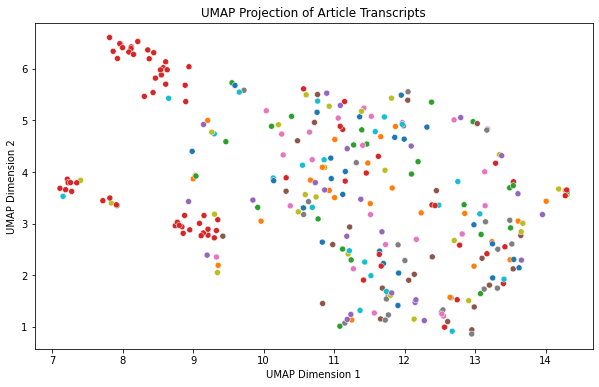

In [11]:
# Step 8: Vectorize Text Using Sentence Transformers
print("Encoding transcripts using Sentence Transformers...")
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(final_df.transcript.tolist(), show_progress_bar=True)
print("Encoding complete.")
# Convert embeddings to a DataFrame
embeddings_df = pd.DataFrame(embeddings)

# Step 9: Apply UMAP for Dimensionality Reduction
umap_embeddings = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine').fit_transform(embeddings)

# Step 10: Visualize the Embeddings
plt.figure(figsize=(10, 6))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=metadata_df["title"], palette="tab10", legend=False)
plt.title("UMAP Projection of Article Transcripts")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


In [12]:
columns = final_df.columns.tolist()
columns.remove('transcript')
final_df[columns].to_csv("subset_africa_media_review_dataset.csv", index=False)